In [1]:
from insight_analyzer import *

# notebook input from an insight
sample = PredictionAnalyzer(insight_id="657f0cc8-fa05-46bb-9808-8cf4f065ce3d")

First we need to setup a `forecaster`, in this example, we are using ForecasterAutoreg from `scikit-learn`. Feel free to use a different one, e.g. SARIMAX from `statsmodels`.

In [2]:
# Set up the Forecaster

# Seed for reproductibility
seed = 123
# number of periods to use as a predictor for the next one
lags = 168

forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=seed),
    lags=lags,
)

Now we need to prepare our data for the forecasting. Our data can be incomplete, so we might want to interpolate it.

In [3]:
df = sample.get_df()
# Interpolate the first column
dim_y = df.columns.values[0]
data_interpolate = df.copy()

# Using linear interpolation. You might want to experiment with different ones.
data_interpolate.loc[:, dim_y] = data_interpolate.loc[:, dim_y].interpolate(
    method="linear"
)

Now we might want to see, how our interpolation went. For this we recommend `matplotlib`, which is included as `plt`.

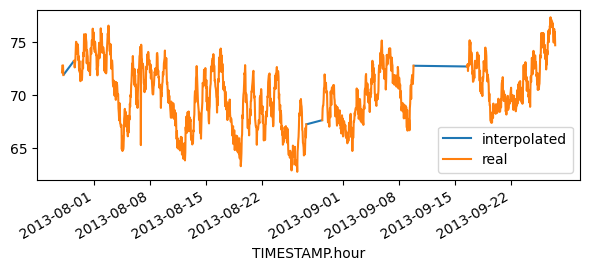

In [4]:
fig, ax = plt.subplots(figsize=(7, 2.5))

missing_values = df[dim_y].isnull()
ax.plot(data_interpolate[dim_y].where(missing_values, np.nan), label="interpolated")
df[dim_y].plot(ax=ax, label="real")

ax.legend()

Now let's forecast the some steps forward. You might want to edit the confidence_interval and/or the steps. In this step we also calculate the lower and upper bounds of the confidence interval.

*NOTE*: Before you interpolate, do not forget to add frequency!

In [5]:
step_count = 50
# Confidence interval is in percent
confidence_interval = 90

# Before we interpolate, do not forget to add frequency!
data_interpolate = data_interpolate.asfreq("H")
forecaster.fit(y=data_interpolate[dim_y])

predictions = forecaster.predict_interval(
    steps=step_count,
    # Interval is calculated as [lower, upper]
    interval=[
        (100-confidence_interval)/2,
        100-((100-confidence_interval)/2)
    ]
)

# Calculate lower and upper bounds
z_score = np.abs(np.percentile(predictions, (100 ) / 2))
lower_bound = predictions - z_score * np.std(predictions)
upper_bound = predictions + z_score * np.std(predictions)

Now let's reuse the plot we already had and add the prediction with confidence interval:

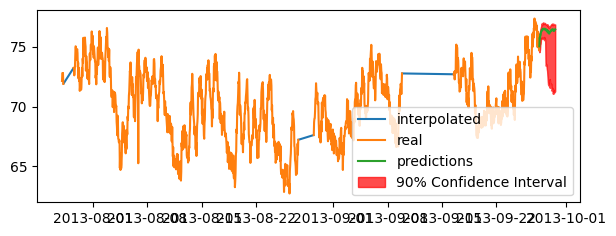

In [6]:
fig, ax = plt.subplots(figsize=(7, 2.5))
missing_values = df[dim_y].isnull()
ax.plot(data_interpolate[dim_y].where(missing_values, np.nan), label="interpolated")
ax.plot(df[dim_y], label="real")

ax.plot(predictions["pred"], label="predictions")
plt.fill_between(
    predictions.index,
    predictions["lower_bound"],
    predictions["upper_bound"],
    color="red",
    alpha=0.7,
    label=f"{confidence_interval}% Confidence Interval",
)
ax.legend()


Awesome! Now we need to propagate the changes back, so you can see them on your dashboard!

In [7]:
sample.push_to_server(predictions,data_interpolate)


AttributeError: 'PredictionAnalyzer' object has no attribute 'result_id'